In [1]:
from data.loaders import load_reddit_data
from preprocessing import RedditText

In [2]:
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import pandas as pd

# Loading in data

In [3]:
submissions, comments = load_reddit_data()

# Assessment of data quality

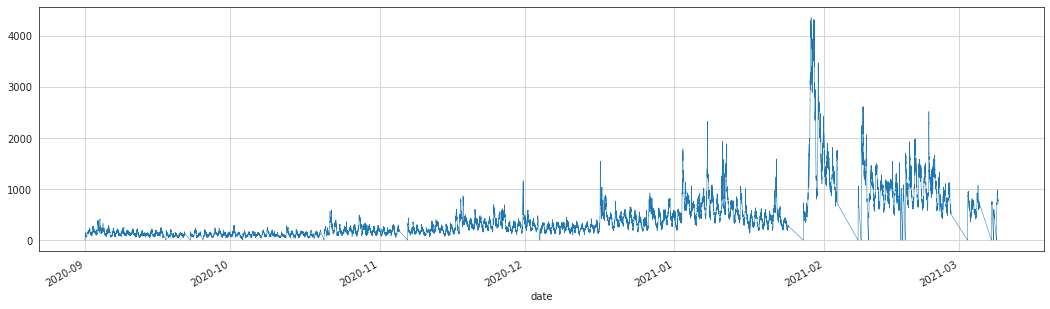

In [4]:
frequency = comments.id.rolling("1h").count()
frequency.plot(figsize=(18,5), linewidth=0.5)
plt.grid()

In [5]:
starts = frequency.loc[frequency==1].reset_index().drop(columns="id").rename(columns={"date":"start"})
ends = frequency.loc[frequency.shift(-1)==1].reset_index().drop(columns="id").rename(columns={"date":"end"})
pd.concat([starts,ends], axis=1)

,start,end
0,2020-09-01 00:00:03,2020-09-17 06:40:01
1,2020-09-17 18:14:55,2020-09-21 15:35:41
2,2020-09-22 19:27:56,2020-09-24 23:21:38
3,2020-09-25 11:00:32,2020-10-19 16:58:22
4,2020-10-20 11:35:33,2020-11-05 00:38:13
5,2020-11-06 18:21:14,2020-12-03 17:57:16
6,2020-12-04 03:47:18,2021-01-24 13:06:23
7,2021-01-27 15:56:51,2021-02-03 20:17:50
8,2021-02-08 00:21:23,2021-02-08 04:22:18
9,2021-02-08 15:44:12,2021-02-09 21:03:47


# Cleaning dataset

In [6]:
try:
    cleanreddit = RedditText("cleanreddit")
    print("loading from cleaned file")
except:
    print("failed, generate cleaned file")
    reddit = RedditText(comments.body)
    cleanreddit = reddit.clean_corpus(save_as="cleanreddit")

loading from cleaned file


<AxesSubplot:ylabel='Frequency'>

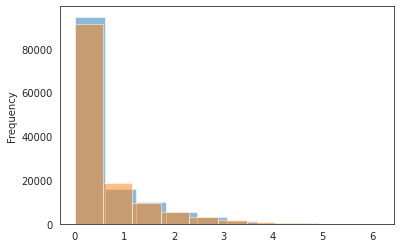

In [7]:
cleanreddit.cfs().wordcount.apply(np.log10).plot(kind="hist", alpha=0.5)
cleanreddit.dfs().wordcount.apply(np.log10).plot(kind="hist", alpha=0.5)

In [8]:
cleanreddit.cfs().tail(25)

,token,wordcount
358,buy,125074
300,don,128042
228,people,131644
261,there,136293
247,more,138576
124,all,146560
162,like,150736
195,what,155853
34,just,191538
97,will,194405


In [9]:
cleanreddit.cfs().loc[cleanreddit.cfs().wordcount<=2].tail(25)

,token,wordcount
56383,tagger,2
110032,posy,2
59125,mcchickens,2
71160,fourties,2
28967,immuculation,2
71171,thumbstick,2
97948,publicaciones,2
59031,righty,2
95790,abezzy,2
95773,jogged,2


In [10]:
cleanreddit.dictionary.filter_extremes(2, 0.9)

# Looking at topics

In [11]:
buzzwords = ["long", "buy", "moon", "pump", "bullish", "sell", "hodl", "hold", "dump", "bearish", "bear"]

In [12]:
try:
    print("try to load model")
    w2v = cleanreddit.train_word2vec("reddit_b2v50")
except:
    print("failed, start training")
    w2v = cleanreddit.train_word2vec(cleanreddit.corpus, bigrams=True, vector_size=50, save_as="reddit_b2v50")

try to load model


In [13]:
#w2v = cleanreddit.word2vec("fasttext-wiki-news-subwords-300")

61540 words in dictionary could be matched with w2v
264 words in dictionary could not be matched with w2v
compute a clustering only with respect to matched words

11 buzzwords could be matched with w2v
0 buzzwords could not be matched with w2v
compute clustering with 5 clusters
compute pca for plotting
Most similar words to centroid 0
     |     cosine similarity: 0.8913 | word: "bernie_sander"
     |     cosine similarity: 0.8893 | word: "lamb"
     |     cosine similarity: 0.8771 | word: "snake"
     |     cosine similarity: 0.8725 | word: "kanye"
     |     cosine similarity: 0.8705 | word: "cry_baby"
     |     cosine similarity: 0.8697 | word: "dancing"
     |     cosine similarity: 0.8695 | word: "kramer"
     |     cosine similarity: 0.8684 | word: "knight"
     |     cosine similarity: 0.8681 | word: "idol"
     |     cosine similarity: 0.868 | word: "drama_queen"
Most similar words to centroid 1
     |     cosine similarity: 0.9893 | word: "ваша"
     |     cosine similarity: 

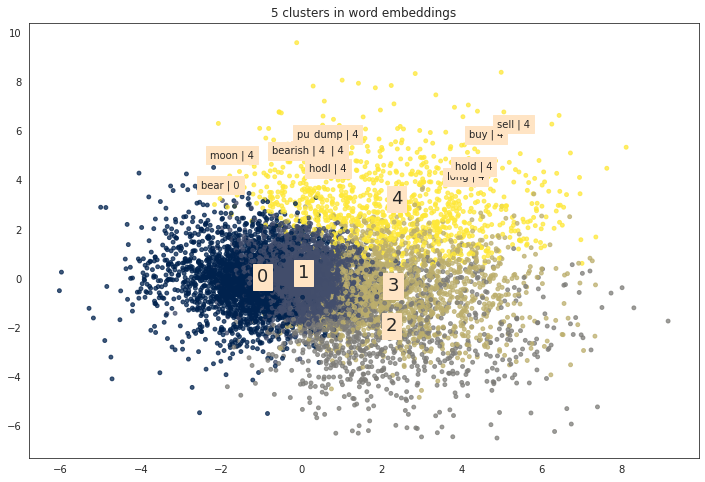

In [14]:
cluster_model, _ = cleanreddit.kmeans(cleanreddit.dictionary, w2v, buzzwords=buzzwords, n_clusters=5)

,long,buy,moon,pump,bullish,sell,hodl,hold,dump,bearish,bear
long,1.000000,0.160292,0.255477,0.161209,0.318584,0.170410,0.257382,0.256185,0.141019,0.296706,0.282645
buy,0.160292,1.000000,0.234085,0.377993,0.154788,0.838230,0.488718,0.569468,0.387168,0.068844,-0.108432
moon,0.255477,0.234085,1.000000,0.382434,0.361627,0.264019,0.406773,0.307437,0.369881,0.272110,0.348648
pump,0.161209,0.377993,0.382434,1.000000,0.460855,0.422026,0.329371,0.316212,0.878936,0.435121,0.445135
bullish,0.318584,0.154788,0.361627,0.460855,1.000000,0.115007,0.257836,0.216880,0.366301,0.889504,0.439919
sell,0.170410,0.838230,0.264019,0.422026,0.115007,1.000000,0.567916,0.680409,0.553988,0.137543,0.057752
hodl,0.257382,0.488718,0.406773,0.329371,0.257836,0.567916,1.000000,0.826180,0.433081,0.191393,0.362438
hold,0.256185,0.569468,0.307437,0.316212,0.216880,0.680409,0.826180,1.000000,0.428242,0.083425,0.173998
dump,0.141019,0.387168,0.369881,0.878936,0.366301,0.553988,0.433081,0.428242,1.000000,0.409228,0.441038
bearish,0.296706,0.068844,0.272110,0.435121,0.889504,0.137543,0.191393,0.083425,0.409228,1.000000,0.608081


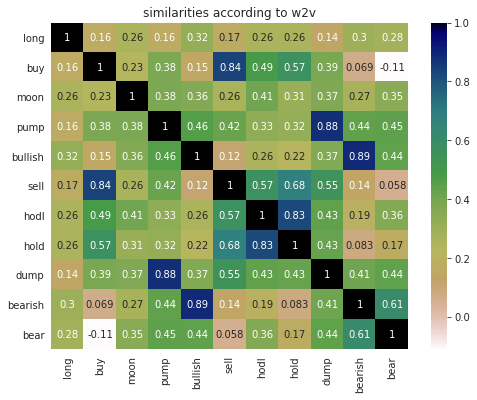

In [15]:
cleanreddit.same_context(w2v, buzzwords)

In [20]:
cleanreddit.more_context(w2v, buzzwords)

context modeled by embedding
----------------------------------------
     | other words in the context of "long":
     |     similarity: 0.6626 | word: "forever"
     |     --------------------------
     |     similarity: 0.6073 | word: "short_period"
     |     --------------------------
     |     similarity: 0.6002 | word: "tooks"
     |     --------------------------
     |     similarity: 0.5943 | word: "lulzgains"
     |     --------------------------
     |     similarity: 0.5841 | word: "least"
     |     --------------------------
     | other words in the context of "buy":
     |     similarity: 0.8382 | word: "sell"
     |     --------------------------
     |     similarity: 0.7824 | word: "rebuy"
     |     --------------------------
     |     similarity: 0.7725 | word: "buying"
     |     --------------------------
     |     similarity: 0.749 | word: "accumulate"
     |     --------------------------
     |     similarity: 0.7426 | word: "acquire"
     |     ---------

In [17]:
num_topics = 5
file_name = f"lda{num_topics}"

In [18]:
try:
    print("try loading lda")
    lda, vis = cleanreddit.lda(cleanreddit.corpus, load=file_name)
except:
    print("failed, train lda")
    lda, vis = cleanreddit.lda(cleanreddit.corpus, num_topics=num_topics, save_as=save_lda)

try loading lda
prepare data
loading lda
generate visualization


In [19]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.009644  0.083194       1        1  25.107379
3     -0.038548  0.034180       2        1  24.337195
2      0.005965 -0.032558       3        1  20.104081
4     -0.092532 -0.050496       4        1  17.048284
0      0.115471 -0.034321       5        1  13.403060, topic_info=        Term           Freq          Total Category  logprob  loglift
10       you  723581.000000  723581.000000  Default  30.0000  30.0000
183   wallet   89765.000000   89765.000000  Default  29.0000  29.0000
115     your  216923.000000  216923.000000  Default  28.0000  28.0000
3247    doge   62173.000000   62173.000000  Default  27.0000  27.0000
136      fee   55821.000000   55821.000000  Default  26.0000  26.0000
...      ...            ...            ...      ...      ...      ...
108     they   26969.621610  217387.673705   Topic5  -4.9443  -0.0773
170     some   19823.396513   97525.172999   Topic5  -5.2522   0.4164
117      all   22101.221132  148705.001492   Topic5  -5.1434   0.1034
10       you   29729.108632  723581.334988   Topic5  -4.8469  -1.1824
44      with   22604.553866  221383.039141   Topic5  -5.1209  -0.2721

[570 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
47         1  0.126011     about
47         2  0.242291     about
47         3  0.218168     about
47         4  0.085696     about
47         5  0.327841     about
...      ...       ...       ...
1512       3  0.641544  yourself
1512       4  0.192021  yourself
1512       5  0.022210  yourself
16790      4  0.996179       zrx
16790      5  0.002017       zrx

[1609 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 3, 5, 1])

# look at movements of handcraftet topics over time

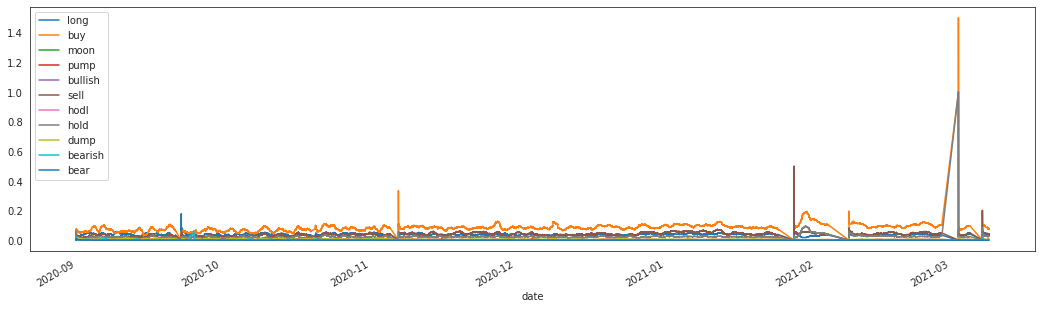

In [21]:
tracked = cleanreddit.track(buzzwords).rolling("1D").mean().plot(figsize=(18,5))